In [1]:
import random
import numpy as np
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import vgg16

In [3]:
from src.dataset import PascalVoc, COLOR_2_INDEX, CLASS_NAMES
from src.utils import batch_mean_iou

In [4]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

In [5]:
path = "data/VOCdevkit/VOC2012/"
seed = 42

img_size = 224
device = "cuda"

In [6]:
batch_size = 20
train_dataset = PascalVoc(path, img_size, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0)

In [7]:
class conv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.bn(x)
        return x

class trans_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels,
                                       kernel_size=3, stride=2,
                                       padding=1, output_padding=1)
        
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.bn(x)
        return x

In [8]:
class u_net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes

        # Indicies used for U-net
        self.un_block_indicies = [(0, 4), (5, 9), (10, 16), 
                                   (17, 23), (24, 30)]
        self.init_vgg()

        self.conv_7x7_1 = conv2d(512, 512)
        self.conv_7x7_2 = conv2d(512, 512)
        
        self.trans_conv_1 = trans_conv2d(512, 256)
        self.trans_conv_2 = trans_conv2d(512, 256)
        self.trans_conv_3 = trans_conv2d(512, 128)
        self.trans_conv_4 = trans_conv2d(256, 64)
        self.trans_conv_5 = trans_conv2d(128, 32)
        
        self.conv_1 = conv2d(256 + 512, 512)
        self.conv_2 = conv2d(256 + 512, 512)
        self.conv_3 = conv2d(128 + 256, 256)
        self.conv_4 = conv2d(64 + 128, 128)

        self.out_conv = nn.Conv2d(32 + 64, num_classes, stride=1, kernel_size=1)
        
    def init_vgg(self):
        model = vgg16(pretrained=True)
        del model.classifier
        model = model.to(device)
        
        self.blocks = []
        
        for block_idx in self.un_block_indicies:
            self.blocks.append(model.features[block_idx[0]:block_idx[1]])
        
        # Freezing the VGG weights
        for block in self.blocks:
            for param in block.parameters():
                param.requires_grad = False        
    
    def forward(self, x):
        x_1 = self.blocks[0](x)
        encoder = F.max_pool2d(x_1, kernel_size=2, stride=2)
        x_2 = self.blocks[1](encoder)
        encoder = F.max_pool2d(x_2, kernel_size=2, stride=2)
        x_3 = self.blocks[2](encoder)
        encoder = F.max_pool2d(x_3, kernel_size=2, stride=2)
        x_4 = self.blocks[3](encoder)
        encoder = F.max_pool2d(x_4, kernel_size=2, stride=2)
        x_5 = self.blocks[4](encoder)
        encoder = F.max_pool2d(x_5, kernel_size=2, stride=2)
        
        encoder = self.conv_7x7_1(encoder)
        encoder = self.conv_7x7_2(encoder)
        
        decoder = self.trans_conv_1(encoder)
        decoder = torch.cat((decoder, x_5), dim=1)
        decoder = self.conv_1(decoder)
        
        decoder = self.trans_conv_2(decoder)
        decoder = torch.cat((decoder, x_4), dim=1)
        decoder = self.conv_2(decoder)
        
        decoder = self.trans_conv_3(decoder)
        decoder = torch.cat((decoder, x_3), dim=1)
        decoder = self.conv_3(decoder)
        
        decoder = self.trans_conv_4(decoder)
        decoder = torch.cat((decoder, x_2), dim=1)
        decoder = self.conv_4(decoder)
        
        decoder = self.trans_conv_5(decoder)
        decoder = torch.cat((decoder, x_1), dim=1)
        decoder = self.out_conv(decoder)
        
        score = F.log_softmax(decoder, dim=1)
        return score

In [9]:
torch.manual_seed(seed)
model = u_net(len(CLASS_NAMES)).to(device)

In [10]:
num_epochs = 40

lr = 2e-3
wd = 1e-5
gamma = 0.5
step_size = 10

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
loss_fct = nn.NLLLoss()

In [11]:
torch.manual_seed(seed)
model.train()
for epoch in range(1, num_epochs+1):
    loss = 0.0
    iou = 0.0
    
    scheduler.step()
    for _, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        y_hat = model(x)
        batch_loss = loss_fct(y_hat, y)
        
        batch_loss.backward()
        optimizer.step()
        
        batch_loss = batch_loss.detach().cpu().numpy()
        loss += batch_loss
        
        preds = torch.argmax(y_hat, dim=1)
        batch_iou = batch_mean_iou(preds.detach().cpu().numpy(), y.detach().cpu().numpy())
        iou += batch_iou
    
    loss = loss / len(train_dataloader)
    iou = iou / len(train_dataloader)
    
    if epoch % 5 == 0:
        print(f"-------Epoch {epoch}-------")
        print(f"Loss : {loss}")
        print(f"Mean IOU: {iou}")

-------Epoch 5-------
Loss : 0.540349666182309
Mean IOU: 0.553190590965741
-------Epoch 10-------
Loss : 0.32421233372329034
Mean IOU: 0.6775618261674219
-------Epoch 15-------
Loss : 0.17090908136882194
Mean IOU: 0.7834901928129422
-------Epoch 20-------
Loss : 0.1283022862897344
Mean IOU: 0.8182943096783262
-------Epoch 25-------
Loss : 0.07455498227619961
Mean IOU: 0.8674176621099307
-------Epoch 30-------
Loss : 0.06319116818884464
Mean IOU: 0.879732523749336
-------Epoch 35-------
Loss : 0.05089029730999307
Mean IOU: 0.8959346335950711
-------Epoch 40-------
Loss : 0.04846749565729948
Mean IOU: 0.8997509801777769


In [12]:
random.seed(seed)
model.eval()

idx = 3
x, _ = train_dataset[idx]
y, _ = train_dataset.load_imgs(idx)
gt = train_dataset.segmentation_imgs[idx]
gt = Image.open(gt).convert("RGB")

x = x.unsqueeze(0)
y_hat = model(x)
y_hat = torch.argmax(y_hat, dim=1)[0, :, :]
y_hat = y_hat.detach().cpu().numpy()

gt = gt.resize((img_size, img_size))
gt = np.array(gt)

In [13]:
y_hat_mask = np.zeros((img_size, img_size, 3))

for i in range(img_size):
    for j in range(img_size):
        y_hat_mask[i, j, :] = COLOR_2_INDEX[y_hat[i, j]]
        
y_hat_mask = y_hat_mask.astype(int)

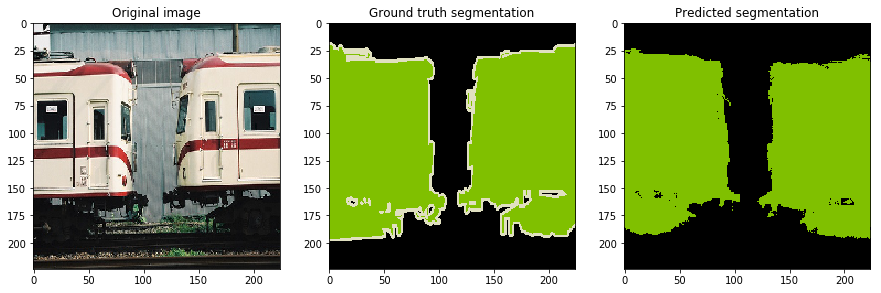

In [14]:
rcParams['figure.figsize'] = 15, 15

plt.subplot(1, 3, 1)
plt.imshow(y)
plt.title("Original image")

plt.subplot(1, 3, 2)
plt.imshow(gt)
plt.title("Ground truth segmentation")

plt.subplot(1, 3, 3)
plt.imshow(y_hat_mask)
plt.title("Predicted segmentation")

plt.show()